In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization


In [2]:
train_df_src = pd.read_csv("../resources/sign_mnist_train.csv")
test_df_src = pd.read_csv("../resources/sign_mnist_test.csv")

In [3]:
train_df_src.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


/Users/eliran.shemtov/DevProjects/sign_lang_rec/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

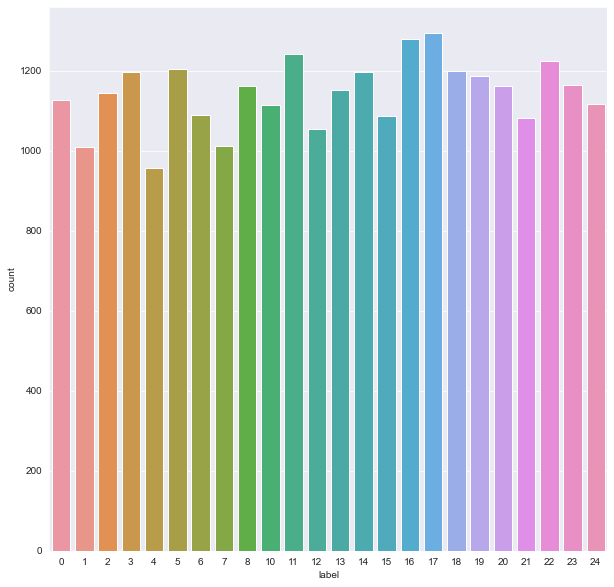

In [4]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df_src['label'])

In [5]:
train_df = train_df_src.copy()
test_df = test_df_src.copy()

train_labels = train_df["label"]
test_labels = test_df["label"]

train_df.drop("label", axis=1, inplace=True)
test_df.drop("label", axis=1, inplace=True)


In [6]:
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)
test_labels = label_binarizer.fit_transform(test_labels)

In [7]:
train_values = train_df.values
test_values = test_df.values

In [8]:
train_values = train_values.reshape(-1,28,28,1)
test_values = test_values.reshape(-1,28,28,1)

In [9]:
train_values = train_values / 255
test_values = test_values / 255

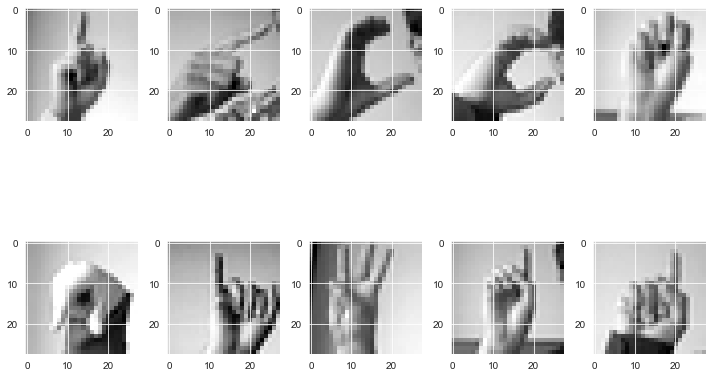

In [10]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(train_values[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()   

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_values)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [14]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0

2021-08-11 19:31:17.701788: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
history = model.fit(datagen.flow(train_values, train_labels, batch_size = 128) ,epochs = 20 , validation_data = (test_values, test_labels) , callbacks = [learning_rate_reduction])
model.save('trained_model.h5')

2021-08-11 19:31:22.984569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
215/215 [==============================] - 57s 161ms/step - loss: 1.7199 - accuracy: 0.4892 - val_loss: 3.6850 - val_accuracy: 0.1567
Epoch 2/20
215/215 [==============================] - 38s 176ms/step - loss: 0.2515 - accuracy: 0.9171 - val_loss: 0.8770 - val_accuracy: 0.7450
Epoch 3/20
215/215 [==============================] - 37s 171ms/step - loss: 0.1009 - accuracy: 0.9673 - val_loss: 0.2870 - val_accuracy: 0.8811
Epoch 4/20
215/215 [==============================] - 36s 168ms/step - loss: 0.0727 - accuracy: 0.9760 - val_loss: 0.0412 - val_accuracy: 0.9854
Epoch 5/20
215/215 [==============================] - 37s 173ms/step - loss: 0.0459 - accuracy: 0.9866 - val_loss: 0.0262 - val_accuracy: 0.9922
Epoch 6/20
215/215 [==============================] - 35s 165ms/step - loss: 0.0382 - accuracy: 0.9867 - val_loss: 0.1467 - val_accuracy: 0.9423
Epoch 7/20
215/215 [==============================] - 37s 170ms/step - loss: 0.0314 - accuracy: 0.9891 - val_loss: 0.0198 - val_ac